In [1]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 3.4.1 Simulate and forecast a random walk 

In [2]:
np.random.seed(40)

steps = np.random.standard_normal(500)
steps[0] = 10

random_walk = np.cumsum(steps)

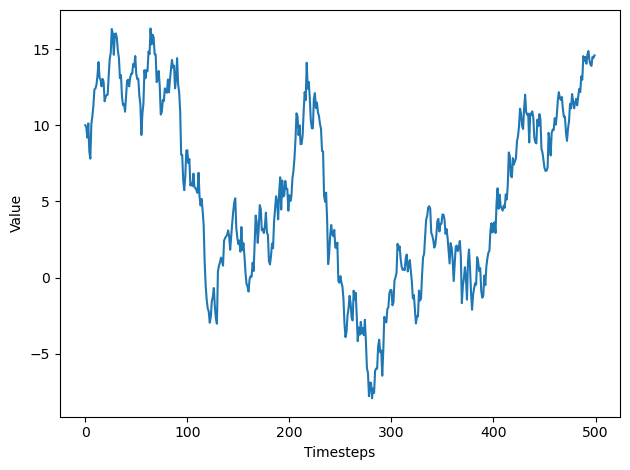

In [3]:
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

In [4]:
ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5913356419504003
p-value: 0.48794444566321066


In [5]:
diff_random_walk = np.diff(random_walk, n=1)

In [6]:
ADF_result = adfuller(diff_random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -21.973525117525828
p-value: 0.0


In [7]:
df = pd.DataFrame({'value': random_walk})

train = df[:400]
test = df[400:]

In [8]:
# Predict the mean
mean = np.mean(train.value)

test.loc[:, 'pred_mean'] = mean

test.head()

,value,pred_mean
400,3.535928,4.571965
401,3.627021,4.571965
402,2.928230,4.571965
403,4.910073,4.571965
404,5.861157,4.571965


In [9]:
# Predict the last known value
last_value = train.iloc[-1].value

test.loc[:, 'pred_last'] = last_value

test.head()

,value,pred_mean,pred_last
400,3.535928,4.571965,2.960159
401,3.627021,4.571965,2.960159
402,2.928230,4.571965,2.960159
403,4.910073,4.571965,2.960159
404,5.861157,4.571965,2.960159


In [10]:
# Predict with drift
deltaX = 400 - 0
deltaY = last_value - 10

drift = deltaY / deltaX

x_vals = np.arange(400, 500, 1)

pred_drift = drift * x_vals + 10

test.loc[:, 'pred_drift'] = pred_drift

test.head()

,value,pred_mean,pred_last,pred_drift
400,3.535928,4.571965,2.960159,2.960159
401,3.627021,4.571965,2.960159,2.942559
402,2.928230,4.571965,2.960159,2.924960
403,4.910073,4.571965,2.960159,2.907360
404,5.861157,4.571965,2.960159,2.889760


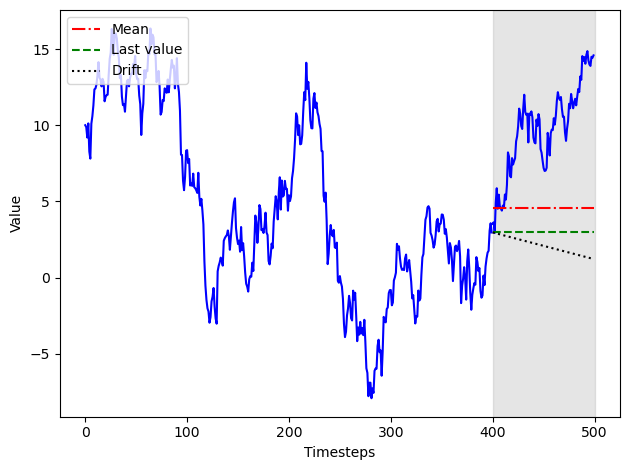

In [11]:
fig, ax = plt.subplots()

ax.plot(train['value'], 'b-')
ax.plot(test['value'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(400, 500, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

In [12]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

34.90129556985135 54.07514083616252 69.38118694822901


In [13]:
# Forecast the next timestep
df_shift = df.shift(periods=1)

mse_one_step = mean_squared_error(test['value'], df_shift[400:])

mse_one_step

0.670898152293387

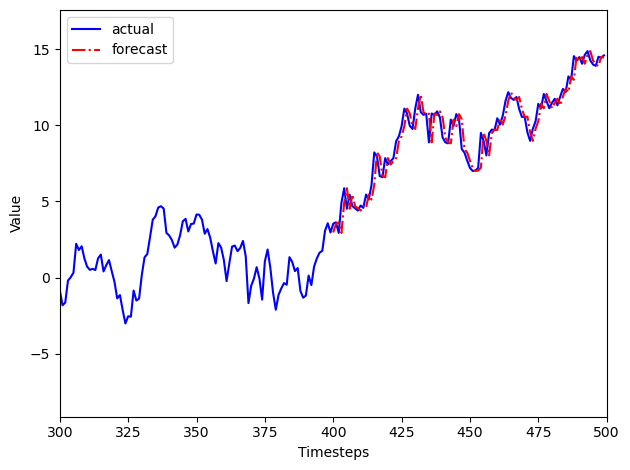

In [14]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift[400:], 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(300, 500)
plt.tight_layout()

## 3.4.2 Forecast the daily closing price of GOOGL 

In [15]:
df = pd.read_csv('../data/GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


In [16]:
# Keep the last five days to test your forecasts

googl_train = df[['Date','Close']][:-5]
googl_test = df[['Date','Close']][-5:]

In [17]:
googl_test

,Date,Close
248,2021-04-21,2278.350098
249,2021-04-22,2252.520020
250,2021-04-23,2299.929932
251,2021-04-26,2309.929932
252,2021-04-27,2290.979980


In [18]:
# Forecast the historical mean
mean = np.mean(googl_train['Close'])
googl_test.loc[:, 'pred_mean'] = mean

# Forecast using the last knwon value
last_value = googl_train['Close'].iloc[-1]
googl_test.loc[:, 'pred_last'] = last_value

# Forecast using the drift
deltaX = len(googl_train)    # The deltaX is basically the length of the training set
deltaY = last_value - googl_train['Close'].iloc[0]    # Remember to subtract the initial value of the training set

drift = deltaY / deltaX

x_vals = np.arange(248, 253, 1)

pred_drift = drift * x_vals + googl_train['Close'].iloc[0]    #A Add the initial value back in the predictions

googl_test.loc[:, 'pred_drift'] = pred_drift

googl_test

,Date,Close,pred_mean,pred_last,pred_drift
248,2021-04-21,2278.350098,1689.993184,2279.01001,2279.010010
249,2021-04-22,2252.520020,1689.993184,2279.01001,2283.075131
250,2021-04-23,2299.929932,1689.993184,2279.01001,2287.140252
251,2021-04-26,2309.929932,1689.993184,2279.01001,2291.205373
252,2021-04-27,2290.979980,1689.993184,2279.01001,2295.270494


In [19]:
googl_mse_mean = mean_squared_error(googl_test['Close'], googl_test['pred_mean'])
googl_mse_last = mean_squared_error(googl_test['Close'], googl_test['pred_last'])
googl_mse_drift = mean_squared_error(googl_test['Close'], googl_test['pred_drift'])

print(googl_mse_mean, googl_mse_last, googl_mse_drift)

356025.96701539395 447.82398976418415 293.3287644069853


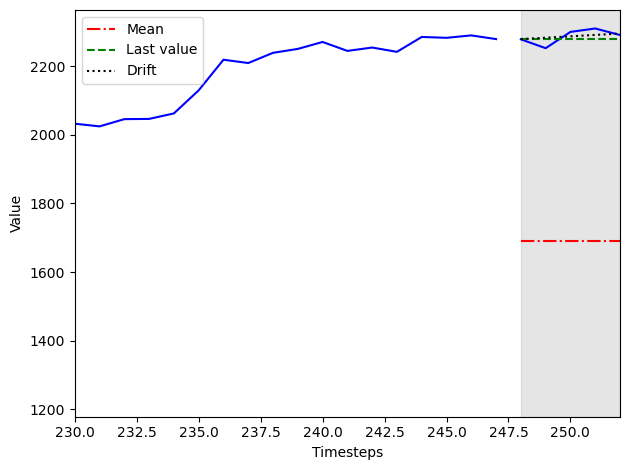

In [20]:
fig, ax = plt.subplots()

ax.plot(googl_train['Close'], 'b-')
ax.plot(googl_test['Close'], 'b-')
ax.plot(googl_test['pred_mean'], 'r-.', label='Mean')
ax.plot(googl_test['pred_last'], 'g--', label='Last value')
ax.plot(googl_test['pred_drift'], 'k:', label='Drift')

ax.axvspan(248, 252, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(230, 252)
plt.tight_layout()

In [21]:
# Forecast the next timestep
df_shift = df.shift(periods=1)

mse_one_step = mean_squared_error(googl_test['Close'], df_shift['Close'].iloc[248:])

mse_one_step

674.8857699967758

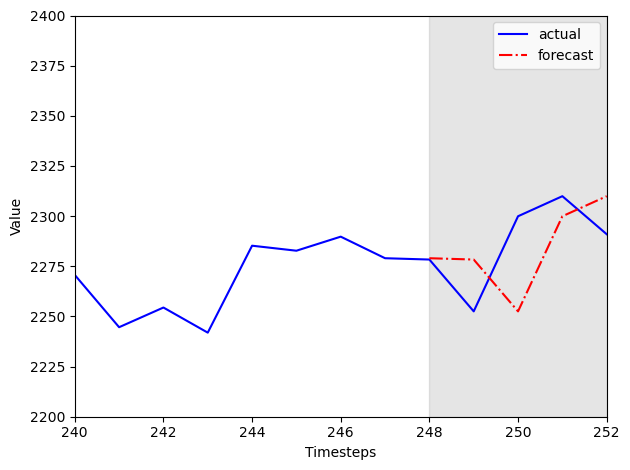

In [22]:
fig, ax = plt.subplots()

ax.plot(df['Close'], 'b-', label='actual')
ax.plot(df_shift['Close'].iloc[248:], 'r-.', label='forecast')

ax.axvspan(248, 252, color='#808080', alpha=0.2)

ax.legend(loc='best')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(240, 252)
plt.ylim(2200, 2400)
plt.tight_layout()

## 3.5.3 Forecast the daily closing price of Apple

In [23]:
df_aapl = pd.read_csv('../data/AAPL.csv')
df_aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-05-31,149.070007,150.660004,146.839996,148.839996,147.956512,103718400
1,2022-06-01,149.899994,151.740005,147.679993,148.710007,147.827301,74286600
2,2022-06-02,147.830002,151.270004,146.860001,151.210007,150.312454,72348100
3,2022-06-03,146.899994,147.970001,144.460007,145.380005,144.517059,88570300
4,2022-06-06,147.029999,148.570007,144.899994,146.139999,145.272537,71598400


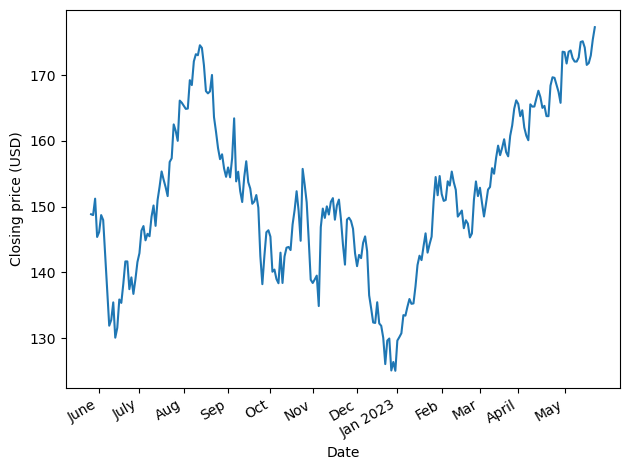

In [28]:
fig, ax = plt.subplots()

ax.plot(df_aapl['Date'], df_aapl['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

plt.xticks(
    [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235], 
    ['June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2023', 'Feb', 'Mar', 'April', 'May'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH03_Exercise_SOlution.png', dpi=300)

In [31]:
ADF_result = adfuller(df_aapl['Close'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.290328174456088
p-value: 0.6335854873709034


### p-value >0.05, which means the time seris is not stationary

In [24]:
# Keep the last five days to test your forecasts

apple_train = df_aapl[['Date','Close']][:-5]
apple_test = df_aapl[['Date','Close']][-5:]

In [25]:
apple_test

,Date,Close
246,2023-05-23,171.559998
247,2023-05-24,171.839996
248,2023-05-25,172.990005
249,2023-05-26,175.429993
250,2023-05-30,177.300003


In [34]:
# Forecast the historical mean
mean = np.mean(apple_train['Close'])
apple_test.loc[:, 'pred_mean'] = mean

# Forecast using the last knwon value
last_value = apple_train['Close'].iloc[-1]
apple_test.loc[:, 'pred_last'] = last_value

# Forecast using the drift
deltaX = len(apple_train)    # The deltaX is basically the length of the training set
deltaY = last_value - apple_train['Close'].iloc[0]    # Remember to subtract the initial value of the training set

drift = deltaY / deltaX

x_vals = np.arange(248, 253, 1)

pred_drift = drift * x_vals + apple_train['Close'].iloc[0]    #A Add the initial value back in the predictions

apple_test.loc[:, 'pred_drift'] = pred_drift

apple_test

,Date,Close,pred_mean,pred_last,pred_drift
246,2023-05-23,171.559998,151.090284,174.199997,174.406176
247,2023-05-24,171.839996,151.090284,174.199997,174.509265
248,2023-05-25,172.990005,151.090284,174.199997,174.612355
249,2023-05-26,175.429993,151.090284,174.199997,174.715444
250,2023-05-30,177.300003,151.090284,174.199997,174.818534


In [35]:
apple_mse_mean = mean_squared_error(apple_test['Close'], apple_test['pred_mean'])
apple_mse_last = mean_squared_error(apple_test['Close'], apple_test['pred_last'])
apple_mse_drift = mean_squared_error(apple_test['Close'], apple_test['pred_drift'])

print(apple_mse_mean, apple_mse_last, apple_mse_drift)

521.7056463953761 5.02524148802358 4.905203225169255


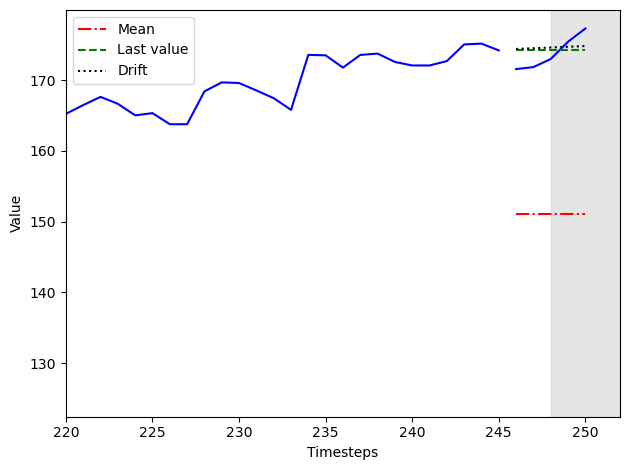

In [38]:
fig, ax = plt.subplots()

ax.plot(apple_train['Close'], 'b-')
ax.plot(apple_test['Close'], 'b-')
ax.plot(apple_test['pred_mean'], 'r-.', label='Mean')
ax.plot(apple_test['pred_last'], 'g--', label='Last value')
ax.plot(apple_test['pred_drift'], 'k:', label='Drift')

ax.axvspan(248, 252, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(220, 252)
plt.tight_layout()